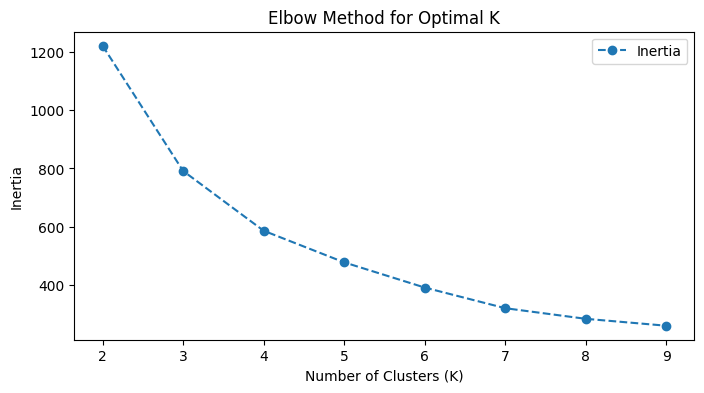

Silhouette Score: 0.3881
Customer segmentation completed and saved successfully!


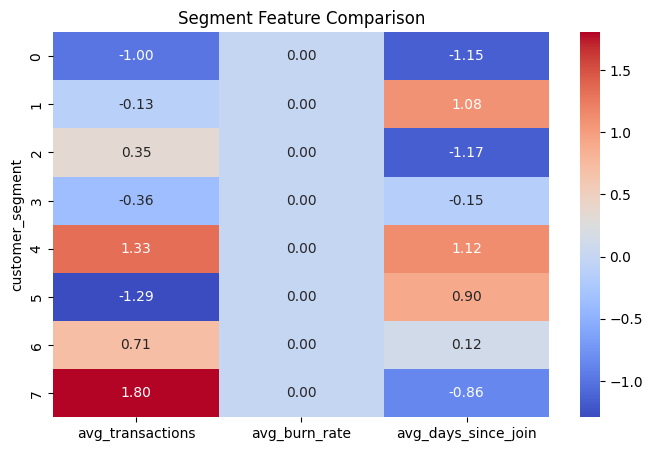

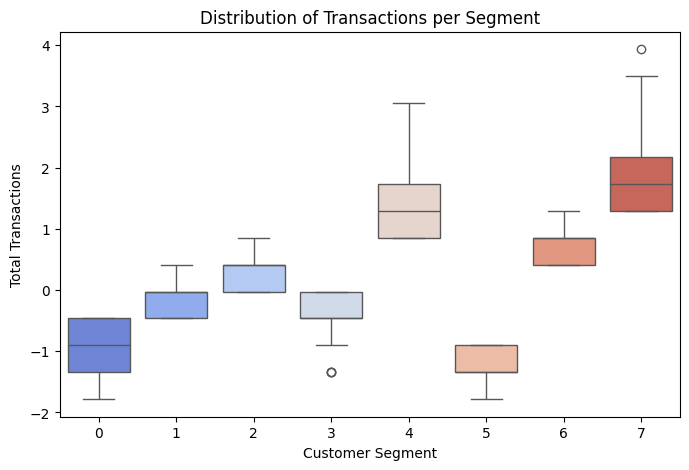

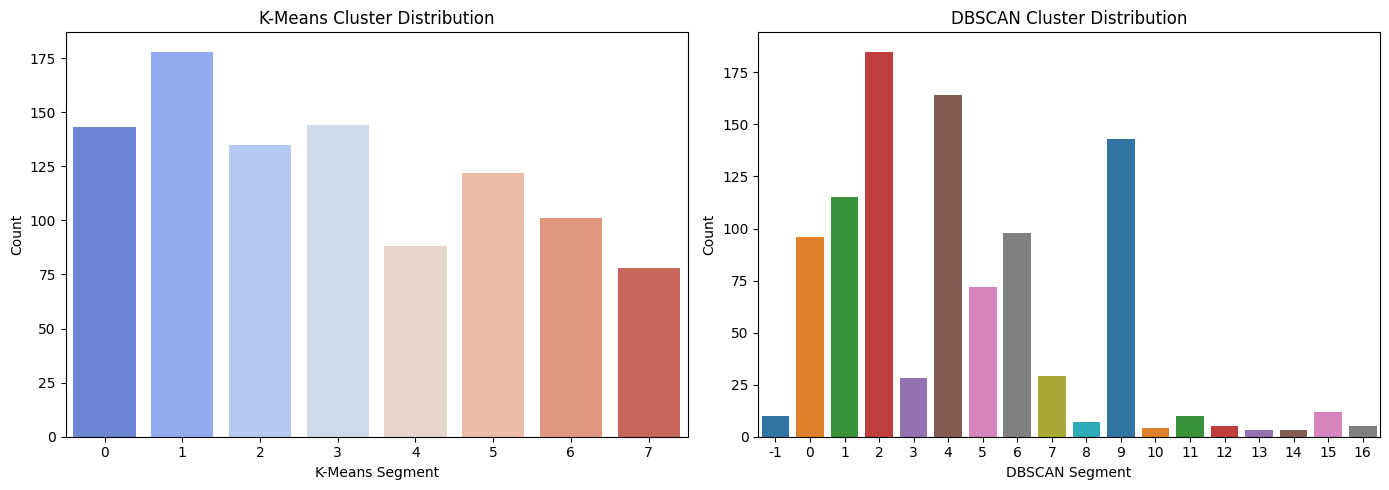

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score

# Load the dataset
df = pd.read_csv(r"C:\Users\mazen\Downloads\E-commerce_segmented_customers.csv")

# Select relevant features
features = ["total_transactions", "burn_rate", "days_since_join"]

# Add demographic features if available
if "gender" in df.columns and "city" in df.columns:
    features.extend(["gender", "city"])

# Add coupon usage and transaction status if available
if "coupon_usage" in df.columns and "transaction_status" in df.columns:
    features.extend(["coupon_usage", "transaction_status"])

# Prepare data for clustering
customer_summary = df.groupby("customer_id")[features].mean().reset_index()
X = customer_summary[features]

# Encode categorical demographic features (if present)
demographic_features = ["gender", "city"]
X = pd.get_dummies(X, columns=[f for f in demographic_features if f in X.columns], drop_first=True)

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Find optimal K using the Elbow Method
inertia = []
silhouette_scores = []
K_range = range(2, 10)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))
    
# Plot the Elbow Curve
plt.figure(figsize=(8, 4))
plt.plot(K_range, inertia, marker="o", linestyle="--", label="Inertia")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimal K")
plt.legend()
plt.show()

# Choose the best K (based on elbow/silhouette)
optimal_k = K_range[np.argmax(silhouette_scores)]

# Final K-Means Model
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
customer_summary["customer_segment"] = kmeans.fit_predict(X_scaled)

# Evaluate model
sil_score = silhouette_score(X_scaled, customer_summary["customer_segment"])
print(f"Silhouette Score: {sil_score:.4f}")

# DBSCAN for Comparison
dbscan = DBSCAN(eps=0.3, min_samples=3)
customer_summary["dbscan_segment"] = dbscan.fit_predict(X_scaled)

# Analyze segments
segment_analysis = customer_summary.groupby("customer_segment").agg(
    avg_transactions=("total_transactions", "mean"),
    avg_burn_rate=("burn_rate", "mean"),
    avg_days_since_join=("days_since_join", "mean"),
    count=("customer_segment", "count")
).reset_index()

# Determine coupon recommendations
segment_analysis["recommend_coupon"] = segment_analysis["avg_transactions"].apply(
    lambda x: "Yes" if x < 3 else "No"
)

#print("Segment Analysis with Coupon Recommendation:\n", segment_analysis)

# Merge segment analysis with customer data
customer_summary = customer_summary.merge(segment_analysis, on="customer_segment", how="left")

# Save full customer segmentation data
customer_summary.to_csv("4!Segmented_Customers.csv", index=False)
print("Customer segmentation completed and saved successfully!")

# Heatmap for segment features
plt.figure(figsize=(8, 5))
sns.heatmap(segment_analysis.set_index("customer_segment").drop(columns=["count", "recommend_coupon"]), 
            annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Segment Feature Comparison")
plt.show()

# Boxplot of Transactions per Segment
plt.figure(figsize=(8, 5))
sns.boxplot(x=customer_summary["customer_segment"], y=customer_summary["total_transactions"], palette="coolwarm")
plt.xlabel("Customer Segment")
plt.ylabel("Total Transactions")
plt.title("Distribution of Transactions per Segment")
plt.show()

# Side-by-side bar plots for K-Means and DBSCAN cluster distributions
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar plot for K-Means cluster distribution
kmeans_counts = customer_summary["customer_segment"].value_counts()
sns.barplot(ax=axes[0], x=kmeans_counts.index, y=kmeans_counts.values, palette="coolwarm")
axes[0].set_xlabel("K-Means Segment")
axes[0].set_ylabel("Count")
axes[0].set_title("K-Means Cluster Distribution")

# Bar plot for DBSCAN cluster distribution
dbscan_counts = customer_summary["dbscan_segment"].value_counts()
sns.barplot(ax=axes[1], x=dbscan_counts.index, y=dbscan_counts.values, palette="tab10")
axes[1].set_xlabel("DBSCAN Segment")
axes[1].set_ylabel("Count")
axes[1].set_title("DBSCAN Cluster Distribution")

plt.tight_layout()
plt.show()

## Customer Segmentation Analysis & Insights

### **📌 Segment 1: High-Value Loyal Customers (Segment 4)**
#### **Characteristics**:
- 🔹 **Highest total transactions** (Frequent coupon users).
- 🔹 **Low burn rate** (Claim coupons but don’t always use them).
- 🔹 **Long-term customers** (Joined a long time ago).

#### **Recommendations**:
✅ Offer **premium, high-value coupons** (e.g., VIP discounts).  
✅ **Personalized loyalty rewards** to keep them engaged.  
✅ **Exclusive promotions** to encourage more coupon burning.

---

### **📌 Segment 2: Inactive Customers (Segment 5)**
#### **Characteristics**:
-  **Very low transaction frequency** (Almost never use coupons).
-  **Zero burn rate** (Claim but never redeem).
-  **Mixed loyalty duration** (Some old, some new).

#### **Recommendations**:
✅ **Reactivation campaigns** (e.g., "We Miss You" discounts).  
✅ **Push notifications/emails** reminding them of expiring coupons.  
✅ **Limited-time offers** to encourage first coupon use.

---

### **📌 Segment 3: Occasional Users (Segment 3)**
#### **Characteristics**:
-  **Moderate transaction frequency**.
-  **Some burn their coupons, some don’t**.
-  **Relatively new customers**.

#### **Recommendations**:
✅ Offer **"Buy More, Save More" deals** to increase frequency.  
✅ **Bonus rewards** for burning coupons (e.g., cashback).  
✅ **Personalized recommendations** based on past coupon usage.

---

### **📌 Segment 4: New & Experimental Users (Segments 1, 2)**
#### **Characteristics**:
-  **Recently joined the platform**.
-  **Trying out coupons but inconsistently**.
-  **Potential future loyal customers**.

#### **Recommendations**:
✅ **Welcome bonuses** (e.g., "First 3 coupons free").  
✅ **Educational content** on how to maximize savings.  
✅ **Gamified incentives** (e.g., "Use 3 coupons, get 1 free").

---

### **📌 Segment 5: Deal Seekers (Small DBSCAN Groups)**
#### **Characteristics**:
-  **High burn rate** (Redeem most coupons they claim).
-  **Very price-sensitive** (Only use coupons when deals are great).
-  **Short-term engagement** (May leave if no deals are available).

#### **Recommendations**:
✅ **Time-limited flash sales** (Encourage immediate purchases).  
✅ **Exclusive deals** for this group (since they actively redeem).  
✅ **Partnership discounts** with other merchants they frequent.
